In [ ]:
!pip install tensorflow-gpu==2.0.0-rc1

     |████████████████████████████████| 380.5MB 42kB/s 
     |████████████████████████████████| 501kB 44.8MB/s 
     |████████████████████████████████| 4.3MB 51.5MB/s 


In [ ]:
!pip install --upgrade tensorflow-gpu


     |████████████████████████████████| 516.2MB 33kB/s 
  Found existing installation: tensorflow-gpu 2.0.0rc1
    Uninstalling tensorflow-gpu-2.0.0rc1:
      Successfully uninstalled tensorflow-gpu-2.0.0rc1


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
tf.__version__

'2.2.0'

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display


In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [ ]:

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# 이 시드를 시간이 지나도 재활용하겠습니다. 
# (GIF 애니메이션에서 진전 내용을 시각화하는데 쉽기 때문입니다.) 
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 주목: 배치사이즈로 None이 주어집니다.

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

generator = make_generator_model()
discriminator = make_discriminator_model()

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

gene_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
discr_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)

train_log_dir = 'logs/gradient_tape/' + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gene_loss(gen_loss)
        discr_loss(disc_loss)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        batch_no = 0
        for image_batch in dataset:
            train_step(image_batch)
            batch_no += 1
            if batch_no % 8 == 0:
              tf.print(gene_loss.result(), discr_loss.result())

        # GIF를 위한 이미지를 바로 생성합니다.
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1,  seed)
        with train_summary_writer.as_default():
            tf.summary.scalar('gen_loss', gene_loss.result(), step=epoch)
            tf.summary.scalar('disc_loss', discr_loss.result(), step=epoch)
        
        # 15 에포크가 지날 때마다 모델을 저장합니다.
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
        # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
        template = 'Epoch {}, gen_loss: {}, disc_loss: {}'
        print(template.format(epoch+1, gene_loss.result(), discr_loss.result()))

        # Reset metrics every epoch
        gene_loss.reset_states()
        discr_loss.reset_states()
    # 마지막 에포크가 끝난 후 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)


In [ ]:
def generate_and_save_images(model, epoch, test_input):
# `training`이 False로 맞춰진 것을 주목하세요.
# 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

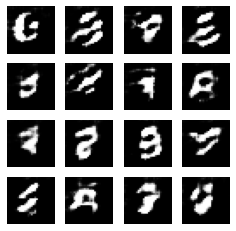

Time for epoch 1 is 25.138341188430786 sec
Epoch 1, gen_loss: 0.8354470729827881, disc_loss: 1.2890387773513794
0.871701241 1.33126462
0.826401114 1.43280041
0.793797791 1.49970627
0.789979458 1.5048362
0.804013431 1.47018504
0.831467688 1.41602218
0.867177844 1.35745692
0.898213565 1.30863225


KeyboardInterrupt: ignored

In [ ]:
%%time
train(train_dataset, EPOCHS)